In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, SVG, display  
import pydotplus
import os
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
bigrams = pd.read_csv("bigrams.csv")


In [3]:
top = bigrams["bigram"].value_counts()
top = top.drop('(born,alive)')

In [4]:
def separate_by_id(bigrams_df):
    df_l = []
    for cid in bigrams["custom_id"].unique():
        df = bigrams[bigrams["custom_id"]==cid]
        df_l.append(df)
    return df_l

In [5]:
def bigram_freq(df_list: [pd.DataFrame], bigrams: [str]):
    dict_list = []
    for df in df_list:
        v = df["bigram"].value_counts()
        d = {"custom_id": df["custom_id"].iloc[0]}
        for bigram in bigrams:
            d[bigram] = 0
            if bigram in v:
                d[bigram] = v[bigram]
        dict_list.append(d)
    return dict_list

In [6]:
df_l = separate_by_id(bigrams)
dl = bigram_freq(df_l, top.index)


In [7]:
bigram_count = pd.DataFrame(dl).set_index("custom_id")

In [8]:
cr = pd.read_csv('Congressional Record.csv')

In [9]:
party = cr.set_index('Congress_id')
party = pd.DataFrame(party['Party'])

bigram_df = bigram_count.join(party)
bigram_df = bigram_df[bigram_df['Party'] != 'Independent Party']

In [10]:
X = bigram_df.loc[:, bigram_df.columns != 'Party']
y = bigram_df['Party']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1) # 70% training and 30% test

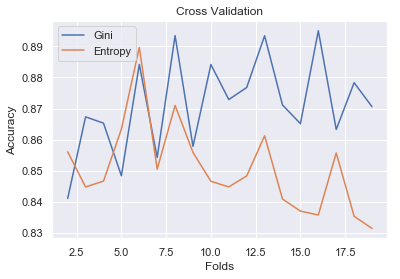

In [11]:
#cross_validation
from sklearn.model_selection import cross_val_score
import seaborn as sns; sns.set()
clf_gini = DecisionTreeClassifier(criterion = 'gini')
clf_entropy = DecisionTreeClassifier(criterion = 'entropy')

num_folds = np.arange(2,20)
gini_list = []
entropy_list = []

for i in num_folds:
    gini_scores = cross_val_score(clf_gini, X, y, cv=i)
    entropy_scores = cross_val_score(clf_entropy,X, y, cv = i)
    gini_list.append(gini_scores.mean())
    entropy_list.append(entropy_scores.mean())
    
ax = sns.lineplot(num_folds,
                  gini_list,
                  label = 'Gini')
ax2 = sns.lineplot(num_folds,
                   entropy_list,
                   label = 'Entropy')
plt.xlabel("Folds")
plt.ylabel("Accuracy")
plt.title("Cross Validation")
plt.show(ax)
    

In [12]:
clf = DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8703703703703703


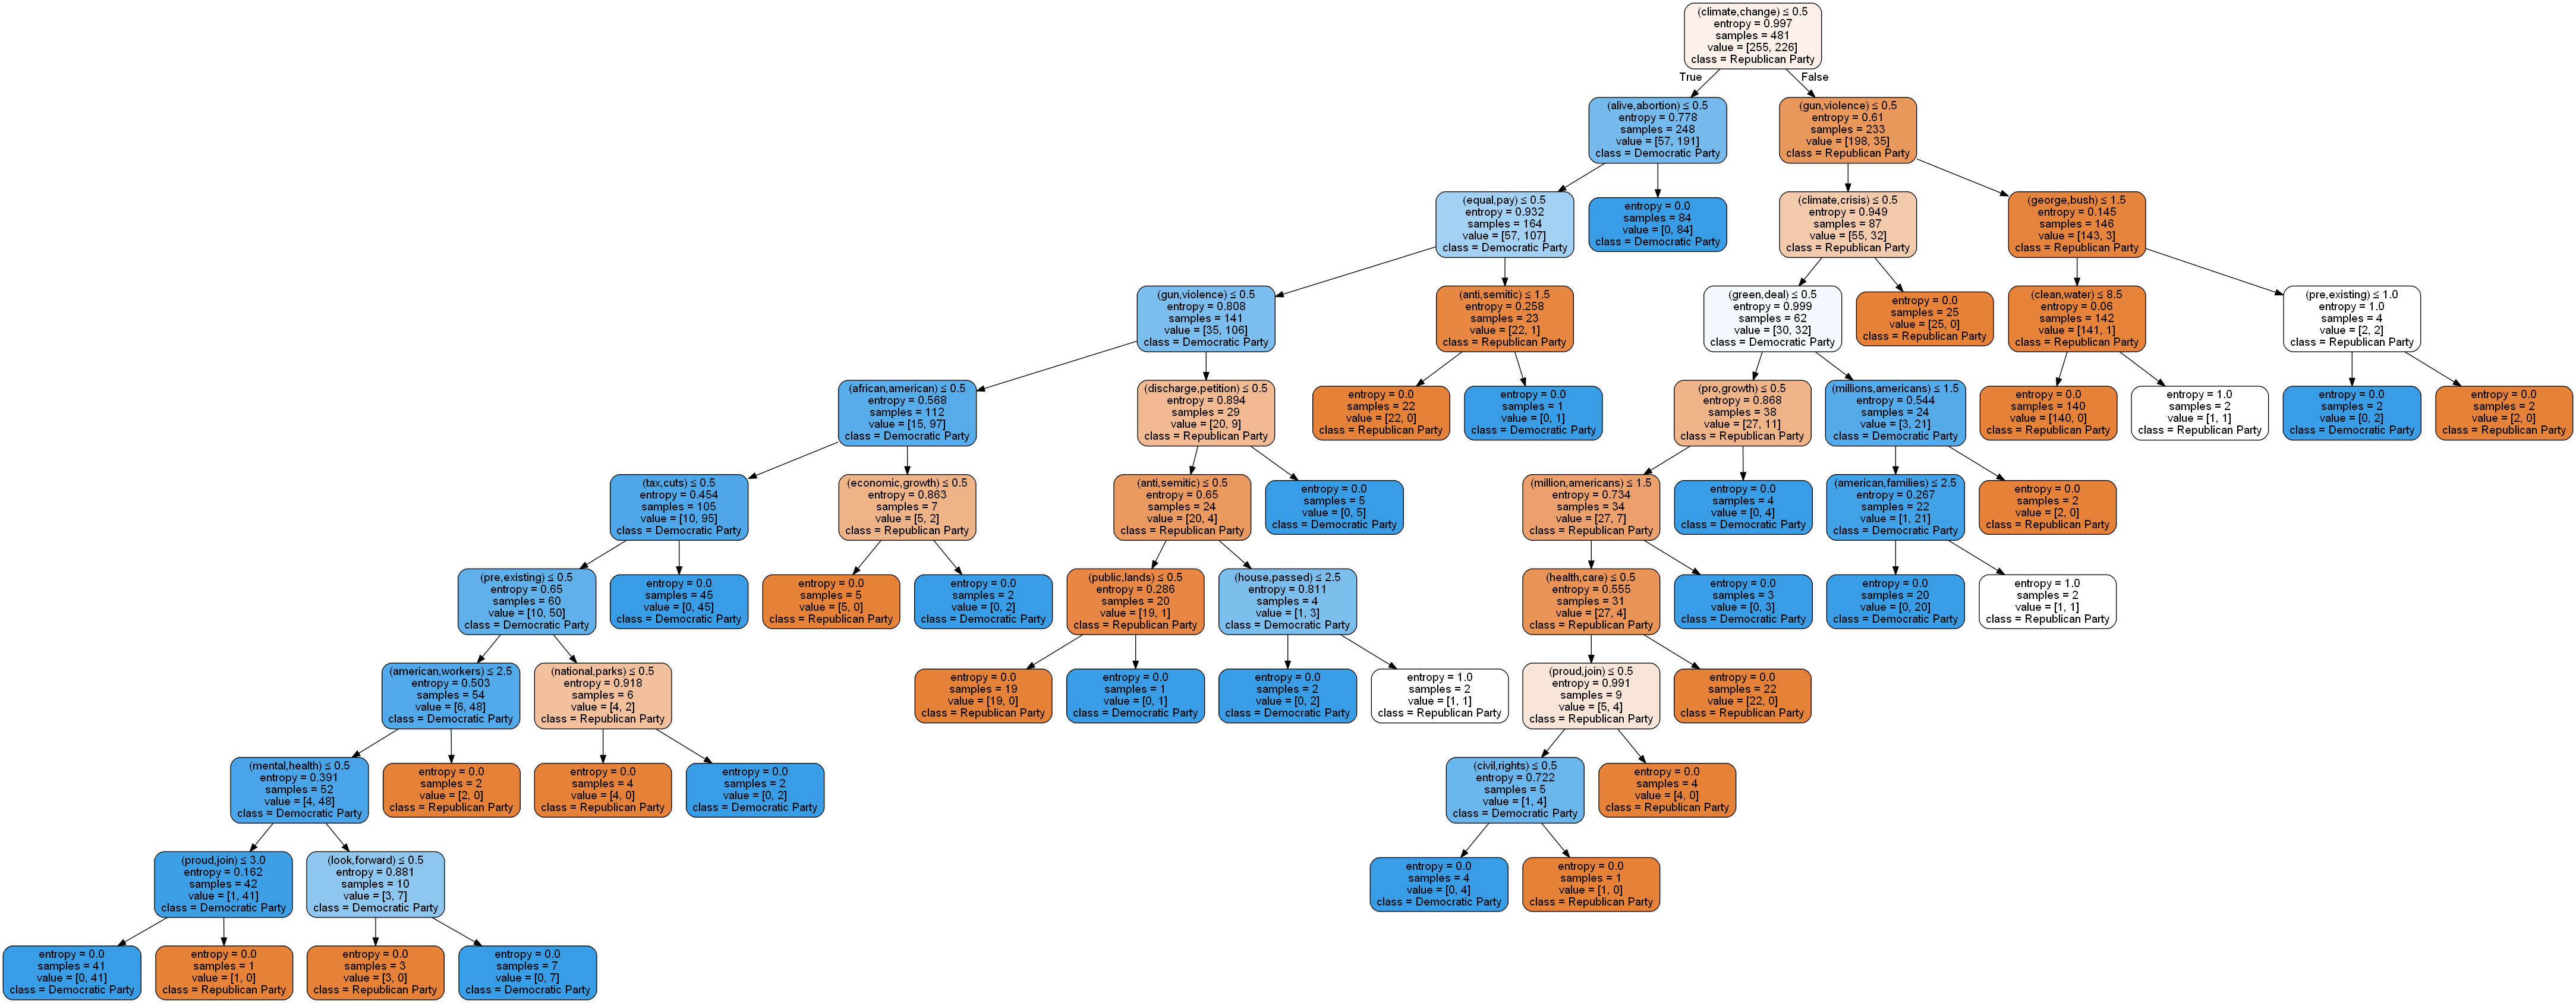

In [13]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns, class_names = sorted(y.unique(), reverse = True))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bigram.png')
Image(graph.create_png())

In [14]:
from ipywidgets import interactive
from graphviz import Source

In [15]:
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)
    estimator.fit(X_train,y_train)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=X.columns
      , class_names= sorted(y.unique(), reverse = True)
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth= np.arange(1,15)
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…